## Compare the output of the different segmentation models

In [1]:
# Set up: Put this in scripts later!!!
import torch
import monai
import torch.nn as nn
from pathlib import Path
import numpy as np
import random
from shutil import copyfile
import os
import nibabel as nib

# Set the random seed for reproducibility
random.seed(2022)

# Read all files ending with _img.nii
img_path = Path("data/data")
img_files = list(img_path.glob("*_img.nii")) # Image and mask are in the same folder
num_images = len(img_files) 

# Create train, validation and test splits
train_split = int(0.8 * num_images)
val_split = int(0.10 * num_images)
test_split = int(num_images - (train_split + val_split))

# Shuffle the image files
random.shuffle(img_files)

# Split the dataset
train_images = img_files[:train_split]
val_images = img_files[train_split:(train_split + val_split)]
test_images = img_files[(train_split + val_split): ]

# Create train, validation and test directories
train_image_dir = Path(img_path / "train_images")
train_mask_dir = Path(img_path / "train_masks")
val_image_dir = Path(img_path / "val_images")
val_mask_dir = Path(img_path / "val_masks")
test_image_dir = Path(img_path / "test_images")
test_mask_dir = Path(img_path / "test_masks")

# Create the directories if they don't exist
if not os.path.exists(train_image_dir) and not os.path.exists(train_mask_dir) and not os.path.exists(val_image_dir) and not os.path.exists(val_mask_dir) and not os.path.exists(test_image_dir) and not os.path.exists(test_mask_dir):
    for directory in [train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir]:
        directory.mkdir(exist_ok = True, parents = True)

    # Copy the images and their corresponding segmentation masks to their respective directories
    for directory, images in zip([train_image_dir, val_image_dir, test_image_dir], [train_images, val_images, test_images]):
        for image in images:
            # Copy image
            copyfile(image, directory / image.name)

            # Get corresponding segmentation mask
            mask = image.name.replace("_img.nii", "_mask.nii")

            # Copy segmentation mask
            copyfile(image.parent / mask, image.parent / directory.name.replace("images", "masks") / mask)


# # Sanity check
# train_images_s = list(train_image_dir.glob("*"))
# train_images_s = [image.name.removesuffix("_img.nii") for image in train_images_s]
# train_masks_s = list(train_mask_dir.glob("*"))
# train_masks_s = [mask.name.removesuffix("_mask.nii") for mask in train_masks_s]
# train_images_s == train_masks_s






import torch
import torch.nn as nn
import torchvision


# Define a Residual block
class residual_block(nn.Module):
    """
    This class implements a residual block which consists of two convolution layers with group normalization
    """
    def __init__(self, in_channels, out_channels, n_groups = 8):
        super().__init__()
        # First convolution layer
        self.first_conv = nn.Conv3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1, bias=False)
        self.first_norm = nn.GroupNorm(num_groups = n_groups, num_channels = out_channels)
        self.act1 = nn.SiLU() # Swish activation function

        # Second convolution layer
        self.second_conv = nn.Conv3d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = 1, bias = False)
        self.second_norm = nn.GroupNorm(num_groups = n_groups, num_channels = out_channels)
        self.act2 = nn.SiLU() # Swish activation function

        # Add dropout to the residual block
        self.dropout = nn.Dropout3d(p = 0.2)

        # If the number of input channels is not equal to the number of output channels,
        # then use a 1X1 convolution layer to compensate for the difference in dimensions
        # This allows the input to have the same dimensions as the output of the residual block
        if in_channels != out_channels:
            self.shortcut = nn.Conv3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, padding = 0, bias = False)
        else:
            # Pass the input as is
            self.shortcut = nn.Identity()

    # Pass the input through the residual block
    def forward(self, x):
        # Store the input
        input = x

        # Pass input through the first convolution layer
        x = self.act1(self.first_norm(self.first_conv(x)))

        # Pass the output of the first convolution layer through the second convolution layer
        x = self.act2(self.second_norm(self.second_conv(x)))

        # Add dropout
        x = self.dropout(x)


        # Add the input to the output of the second convolution layer
        # This is the skip connection
        x = x + self.shortcut(input)
        return x

# Implement the DownSample block that occurs after each residual block
class down_sample(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool3d(kernel_size = 2, stride = 2)

    # Pass the input through the downsample block
    def forward(self, x):
        x = self.max_pool(x)
        return x

# Implement the UpSample block that occurs in the decoder path/expanding path
class up_sample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Convolution transpose layer to upsample the input
        self.up_sample = nn.ConvTranspose3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 2, stride = 2, bias = False)

    # Pass the input through the upsample block
    def forward(self, x):
        x = self.up_sample(x)
        return x

# Implement the crop and concatenate layer
class crop_and_concatenate(nn.Module):
    def forward(self, upsampled, bypass):
        # Crop the upsampled feature map to match the dimensions of the bypass feature map
        if upsampled.shape[2:] != bypass.shape[2:]:
            upsampled = nn.Upsample(size = bypass.shape[2:], mode="trilinear", align_corners=True)(upsampled)

        #upsampled = torchvision.transforms.functional.resize(upsampled, size = bypass.shape[2:], antialias=True)
        x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
        return x

# Implement an attention block
class attention_block(nn.Module):
    def __init__(self, skip_channels, gate_channels, inter_channels = None, n_groups = 8):
        super().__init__()

        if inter_channels is None:
            inter_channels = skip_channels // 2

        # Implement W_g i.e the convolution layer that operates on the gate signal
        # Upsample gate signal to be the same size as the skip connection
        self.W_g = up_sample(in_channels = gate_channels, out_channels = skip_channels)
        self.W_g_norm = nn.GroupNorm(num_groups = n_groups, num_channels = skip_channels)
        self.W_g_act = nn.SiLU() # Swish activation function

        # Implement W_x i.e the convolution layer that operates on the skip connection
        self.W_x = nn.Conv3d(in_channels = skip_channels, out_channels = inter_channels, kernel_size = 1, padding = 0, bias = False)
        self.W_x_norm = nn.GroupNorm(num_groups = n_groups, num_channels = inter_channels)
        self.W_x_act = nn.SiLU() # Swish activation function

        # Implement phi i.e the convolution layer that operates on the output of W_x + W_g
        self.phi = nn.Conv3d(in_channels = inter_channels, out_channels = 1, kernel_size = 1, padding = 0, bias = False)
        #self.phi_norm = nn.GroupNorm(num_groups = n_groups, num_channels = 1)
        #self.phi_act = nn.SiLU() # Swish activation function

        # Implement the sigmoid activation function
        self.sigmoid = nn.Sigmoid()
        # Implement the Swish activation function
        self.act = nn.SiLU()

        # Implement final group normalization layer
        self.final_norm = nn.GroupNorm(num_groups = n_groups, num_channels = skip_channels)

    # Pass the input through the attention block
    def forward(self, skip_connection, gate_signal):
        # Upsample the gate signal to match the channels of the skip connection
        gate_signal = self.W_g(gate_signal)
        # Ensure that the sizes of the skip connection and the gate signal match before addition
        if gate_signal.shape[2:] != skip_connection.shape[2:]:
            gate_signal = nn.Upsample(size = skip_connection.shape[2:], mode="trilinear", align_corners=True)(gate_signal)
            #gate_signal = torchvision.transforms.functional.resize(gate_signal, size = skip_connection.shape[2:], antialias=True)
        # Project to the intermediate channels
        gate_signal = self.W_x(gate_signal)

        # Project the skip connection to the intermediate channels
        skip_signal = self.W_x(skip_connection)

        # Add the skip connection and the gate signal
        add_xg = gate_signal + skip_signal

        # Pass the output of the addition through the activation function
        add_xg = self.act(add_xg)

        # Pass the output of attention through a 1x1 convolution layer to obtain the attention map
        attention_map = self.sigmoid(self.phi(add_xg))

        # Multiply the skip connection with the attention map
        # Perform element-wise multiplication
        skip_connection = torch.mul(skip_connection, attention_map)

        skip_connection = nn.Conv3d(in_channels = skip_connection.shape[1], out_channels = skip_connection.shape[1], kernel_size = 1, bias=False).to(device)(skip_connection)
        skip_connection = self.act(self.final_norm(skip_connection))

        return skip_connection

## Implement a MTL 3D resiidual attention U-Net in a more robust manner
class MTLResidualAttention3DUnet(nn.Module):
    def __init__(self, in_channels, main_out_channels, aux_out_channels, n_channels = [32, 64, 128, 256, 512], gated_attention = False):
        super().__init__()
        
        # Choose whether to use gated attention or not
        self.gated_attention = gated_attention

        # Define the contracting path: residual blocks followed by downsampling
        self.down_conv = nn.ModuleList()
        in_chans = in_channels
        for out_chans in n_channels[:-1]: # Skip the last element since it is the bottleneck
            self.down_conv.append(residual_block(in_chans, out_chans))
            in_chans = out_chans
        
        self.down_samples = nn.ModuleList(down_sample() for _ in range(len(n_channels) - 1))

        # Define the bottleneck residual block
        self.bottleneck = residual_block(in_channels = n_channels[-2], out_channels = n_channels[-1])

        ## ------ Decoder block for segmenting main prostate zones: central, transition, background ------ ##
        # Define the attention blocks
        self.attention_blocks_main = nn.ModuleList()
        for gate_chans, residual_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.attention_blocks_main.append(attention_block(skip_channels = residual_chans, gate_channels = gate_chans))
        
        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples_main = nn.ModuleList()
        for in_chans, out_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.upsamples_main.append(up_sample(in_chans, out_chans))
        
        self.concat_main = nn.ModuleList(crop_and_concatenate() for _ in range(len(n_channels) - 1))

        self.up_conv_main = nn.ModuleList()
        for in_chans, out_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.up_conv_main.append(residual_block(in_chans, out_chans))

        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv_main = nn.Conv3d(in_channels = n_channels[0], out_channels = main_out_channels, kernel_size = 1, padding = 0, bias = False) # 


        ## ------ Decoder block for segmenting the auxilliary zones: Bladder, Rectum, Seminal vesicle, Neurovascular bundle ------ ##
        # Define the attention blocks
        self.attention_blocks_aux = nn.ModuleList()
        for gate_chans, residual_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.attention_blocks_aux.append(attention_block(skip_channels = residual_chans, gate_channels = gate_chans))

        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples_aux = nn.ModuleList()
        for in_chans, out_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.upsamples_aux.append(up_sample(in_chans, out_chans))
        
        self.concat_aux = nn.ModuleList(crop_and_concatenate() for _ in range(len(n_channels) - 1))

        self.up_conv_aux = nn.ModuleList()
        for in_chans, out_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.up_conv_aux.append(residual_block(in_chans, out_chans))

        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv_aux = nn.Conv3d(in_channels = n_channels[0], out_channels = aux_out_channels, kernel_size = 1, padding = 0, bias = False)


    # Pass the input through the residual attention U-Net
    # The input is a 5D tensor of shape (batch_size, channels, depth, height, width)
    def forward(self, x):
        # Store the skip connections
        skip_connections = []

        # Pass the input through the contracting path
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            x = down_sample(x)

        # Pass the output of the contracting path through the bottleneck
        x = self.bottleneck(x)

        # Define the main and auxilliary variables
        x_main = x
        x_aux = x

        # --- Pass the output of the encoder through the decoder of the main prostate zones --- #
        # Initialize the attention block counter and the skip connection counter
        attn_block_count = 0
        skip_connections_count = len(skip_connections)

        # Pass the output of the attention blocks through the expanding path
        if self.gated_attention:
            for up_sample, concat, up_conv in zip(self.upsamples_main, self.concat_main, self.up_conv_main):
                gated_attn = self.attention_blocks_main[attn_block_count](skip_connections[skip_connections_count - 1], x_main)
                attn_block_count += 1
                skip_connections_count -= 1
                x_main = up_sample(x_main)
                x_main = concat(x_main, gated_attn)
                x_main = up_conv(x_main)
        else:
            for up_sample, concat, up_conv in zip(self.upsamples_main, self.concat_main, self.up_conv_main):
                x_main = up_sample(x_main)
                x_main = concat(x_main, skip_connections[skip_connections_count - 1])
                x_main = up_conv(x_main)
                skip_connections_count -= 1
        
        # Pass the output of the main decoder through the final convolution layer
        x_main = self.final_conv_main(x_main)  # Output segmentation map for the main prostate zones

        # --- Pass the output of the encoder through the decoder of the auxilliary prostate zones --- #
        # Initialize the attention block counter and the skip connection counter
        attn_block_count = 0
        skip_connections_count = len(skip_connections)

        # Pass the output of the attention blocks through the expanding path
        if self.gated_attention:
            for up_sample, concat, up_conv in zip(self.upsamples_aux, self.concat_aux, self.up_conv_aux):
                gated_attn = self.attention_blocks_aux[attn_block_count](skip_connections[skip_connections_count - 1], x_aux)
                attn_block_count += 1
                skip_connections_count -= 1
                x_aux = up_sample(x_aux)
                x_aux = concat(x_aux, gated_attn)
                x_aux = up_conv(x_aux)
        else:
            for up_sample, concat, up_conv in zip(self.upsamples_aux, self.concat_aux, self.up_conv_aux):
                x_aux = up_sample(x_aux)
                x_aux = concat(x_aux, skip_connections[skip_connections_count - 1])
                x_aux = up_conv(x_aux)
                skip_connections_count -= 1
            
        # Pass the output of the auxilliary decoder through the final convolution layer
        x_aux = self.final_conv_aux(x_aux) # Output segmentation map for the auxilliary prostate zones

        # Return the output segmentation maps for the main and auxilliary prostate zones
        return x_main, x_aux

# Test whether the model is working
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# modelt = MTLResidualAttention3DUnet(in_channels = 1, main_out_channels = 3, aux_out_channels = 4, n_channels = [32, 64, 128, 256, 512], gated_attention = False).to(device)
# x = torch.randn(2, 1, 40, 128, 128).to(device)
# x_main, x_aux = modelt(x)
# x_main.shape, x_aux.shape


## Implement base model
## Implement a MTL 3D resiidual attention U-Net in a more robust manner
class base_MTLResidualAttention3DUnet(nn.Module):
    def __init__(self, in_channels, main_out_channels, n_channels = [32, 64, 128, 256, 512], gated_attention = False):
        super().__init__()
        
        # Choose whether to use gated attention or not
        self.gated_attention = gated_attention

        # Define the contracting path: residual blocks followed by downsampling
        self.down_conv = nn.ModuleList()
        in_chans = in_channels
        for out_chans in n_channels[:-1]: # Skip the last element since it is the bottleneck
            self.down_conv.append(residual_block(in_chans, out_chans))
            in_chans = out_chans
        
        self.down_samples = nn.ModuleList(down_sample() for _ in range(len(n_channels) - 1))

        # Define the bottleneck residual block
        self.bottleneck = residual_block(in_channels = n_channels[-2], out_channels = n_channels[-1])

        ## ------ Decoder block for segmenting main prostate zones: central, transition, background ------ ##
        # Define the attention blocks
        self.attention_blocks_main = nn.ModuleList()
        for gate_chans, residual_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.attention_blocks_main.append(attention_block(skip_channels = residual_chans, gate_channels = gate_chans))
        
        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples_main = nn.ModuleList()
        for in_chans, out_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.upsamples_main.append(up_sample(in_chans, out_chans))
        
        self.concat_main = nn.ModuleList(crop_and_concatenate() for _ in range(len(n_channels) - 1))

        self.up_conv_main = nn.ModuleList()
        for in_chans, out_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
            self.up_conv_main.append(residual_block(in_chans, out_chans))

        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv_main = nn.Conv3d(in_channels = n_channels[0], out_channels = main_out_channels, kernel_size = 1, padding = 0, bias = False) # 


        # ## ------ Decoder block for segmenting the auxilliary zones: Bladder, Rectum, Seminal vesicle, Neurovascular bundle ------ ##
        # # Define the attention blocks
        # self.attention_blocks_aux = nn.ModuleList()
        # for gate_chans, residual_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
        #     self.attention_blocks_aux.append(attention_block(skip_channels = residual_chans, gate_channels = gate_chans))

        # # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        # self.upsamples_aux = nn.ModuleList()
        # for in_chans, out_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
        #     self.upsamples_aux.append(up_sample(in_chans, out_chans))
        
        # self.concat_aux = nn.ModuleList(crop_and_concatenate() for _ in range(len(n_channels) - 1))

        # self.up_conv_aux = nn.ModuleList()
        # for in_chans, out_chans in zip(n_channels[::-1][:-1], n_channels[::-1][1:]):
        #     self.up_conv_aux.append(residual_block(in_chans, out_chans))

        # # Final 1X1 convolution layer to produce the output segmentation map:
        # # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # # while leaving the spatial dimensions unchanged.
        # self.final_conv_aux = nn.Conv3d(in_channels = n_channels[0], out_channels = aux_out_channels, kernel_size = 1, padding = 0, bias = False)


    # Pass the input through the residual attention U-Net
    # The input is a 5D tensor of shape (batch_size, channels, depth, height, width)
    def forward(self, x):
        # Store the skip connections
        skip_connections = []

        # Pass the input through the contracting path
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            x = down_sample(x)

        # Pass the output of the contracting path through the bottleneck
        x = self.bottleneck(x)

        # Define the main and auxilliary variables
        x_main = x
        #x_aux = x

        # --- Pass the output of the encoder through the decoder of the main prostate zones --- #
        # Initialize the attention block counter and the skip connection counter
        attn_block_count = 0
        skip_connections_count = len(skip_connections)

        # Pass the output of the attention blocks through the expanding path
        if self.gated_attention:
            for up_sample, concat, up_conv in zip(self.upsamples_main, self.concat_main, self.up_conv_main):
                gated_attn = self.attention_blocks_main[attn_block_count](skip_connections[skip_connections_count - 1], x_main)
                attn_block_count += 1
                skip_connections_count -= 1
                x_main = up_sample(x_main)
                x_main = concat(x_main, gated_attn)
                x_main = up_conv(x_main)
        else:
            for up_sample, concat, up_conv in zip(self.upsamples_main, self.concat_main, self.up_conv_main):
                x_main = up_sample(x_main)
                x_main = concat(x_main, skip_connections[skip_connections_count - 1])
                x_main = up_conv(x_main)
                skip_connections_count -= 1
        
        # Pass the output of the main decoder through the final convolution layer
        x_main = self.final_conv_main(x_main)  # Output segmentation map for the main prostate zones

        # # --- Pass the output of the encoder through the decoder of the auxilliary prostate zones --- #
        # # Initialize the attention block counter and the skip connection counter
        # attn_block_count = 0
        # skip_connections_count = len(skip_connections)

        # # Pass the output of the attention blocks through the expanding path
        # if self.gated_attention:
        #     for up_sample, concat, up_conv in zip(self.upsamples_aux, self.concat_aux, self.up_conv_aux):
        #         gated_attn = self.attention_blocks_aux[attn_block_count](skip_connections[skip_connections_count - 1], x_aux)
        #         attn_block_count += 1
        #         skip_connections_count -= 1
        #         x_aux = up_sample(x_aux)
        #         x_aux = concat(x_aux, gated_attn)
        #         x_aux = up_conv(x_aux)
        # else:
        #     for up_sample, concat, up_conv in zip(self.upsamples_aux, self.concat_aux, self.up_conv_aux):
        #         x_aux = up_sample(x_aux)
        #         x_aux = concat(x_aux, skip_connections[skip_connections_count - 1])
        #         x_aux = up_conv(x_aux)
        #         skip_connections_count -= 1
            
        # # Pass the output of the auxilliary decoder through the final convolution layer
        # x_aux = self.final_conv_aux(x_aux) # Output segmentation map for the auxilliary prostate zones

        # Return the output segmentation maps for the main and auxilliary prostate zones
        return x_main#, x_aux

# Test whether the model is working
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# modelt = MTLResidualAttention3DUnet(in_channels = 1, main_out_channels = 3, aux_out_channels = 4, n_channels = [32, 64, 128, 256, 512], gated_attention = False).to(device)
# x = torch.randn(2, 1, 40, 128, 128).to(device)
# x_main, x_aux = modelt(x)
# x_main.shape, x_aux.shape

        

#!pip install monai
from monai.utils import first, set_determinism 
from monai.transforms import (
    EnsureChannelFirstd, # Adjust or add the channel dimension of input data to ensure channel_first shape.
    #AddChanneld,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    NormalizeIntensityd,
    ScaleIntensityd,
    Spacingd,
    SpatialPadd,
    ToTensord,
    RandAffined, Resized, RandSpatialCropd,
    CropForegroundd, # Crop the foreground region of the input image based on the provided mask to help training and evaluation if the valid part is small in the whole medical image
    RandCropByPosNegLabeld, # Crop random patches from image and label based on positive / negative label ratio.
    RandGaussianNoised, # Randomly add Gaussian noise to image.
    RandGaussianSmoothd, # Randomly smooth image with Gaussian filter.
    AdjustContrastd, # Adjust image contrast by gamma value.

)

# Set deterministic training for reproducibility
set_determinism(seed = 2056)

# Put the train images and masks in a dictionary
train_images = sorted(train_image_dir.glob("*"))
train_masks = sorted(train_mask_dir.glob("*"))
train_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(train_images, train_masks)]

# Put the validation images and masks in a dictionary
val_images = sorted(val_image_dir.glob("*"))
val_masks = sorted(val_mask_dir.glob("*"))
val_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(val_images, val_masks)]

# Put the test images and masks in a dictionary
test_images = sorted(test_image_dir.glob("*"))
test_masks = sorted(test_mask_dir.glob("*"))
test_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(test_images, test_masks)]

# Create transforms for training
train_transforms = Compose(
    [
        LoadImaged(keys = ["image", "mask"]),
        EnsureChannelFirstd(keys = ["image", "mask"]),
        ScaleIntensityd(keys = "image"),
        CropForegroundd(keys = ["image", "mask"], source_key = "image"),
        Spacingd(
            keys = ["image", "mask"],
            pixdim = [0.75, 0.75, 2.5],
            mode = ("bilinear", "nearest"), # Interpolation mode for image and mask
        ),
        # RandCropByPosNegLabeld(
        #     keys = ["image", "mask"],
        #     label_key = "mask",
        #     spatial_size = (256, 256, 40), # Output size of the image [height, width, depth]
        #     pos = 1, # Ratio of positive labels in the output image
        #     neg = 1, # Ratio of negative labels in the output image
        #     num_samples = 4, # Number of random crops
        #     image_key = "image", # Key of the image to be cropped
        #     image_threshold = 0# Threshold to determine the foreground of the image
        # ),
        RandAffined(
            keys = ["image", "mask"],
            mode = ("bilinear", "nearest"),
            prob = 1.0,
            spatial_size = (256, 256, 40), # Output size of the image [height, width, depth]
            rotate_range = (np.pi / 36, np.pi / 36, np.pi / 36), # Rotation range
            scale_range = (0.1, 0.1, 0.1), # will do [-0.1, 0.1] scaling then add 1 so a scaling in the range [0.9, 1.1]
            padding_mode="zeros", # This means that the image will be padded with zeros, some images are smaller than 256x256x40
        ),
        RandGaussianNoised(
            keys = "image",
            prob = 0.15,
            mean = 0.0,
            std = 0.1

        ),
        RandGaussianSmoothd(
            keys = "image",
            prob = 0.1,
            sigma_x=(0.5, 1.5),
            sigma_y=(0.5, 1.5),
            sigma_z=(0.5, 1.5)
        ),
        AdjustContrastd(
            keys = "image",
            gamma = 1.3
        )



        
    ]
)

# Create transforms for validation
val_transforms = Compose(
    [
        LoadImaged(keys = ["image", "mask"]),
        EnsureChannelFirstd(keys = ["image", "mask"]),
        ScaleIntensityd(keys = "image"),
        CropForegroundd(keys = ["image", "mask"], source_key = "image"),
        Spacingd(
            keys = ["image", "mask"],
            pixdim = [0.75, 0.75, 2.5],
            mode = ("bilinear", "nearest"),
        ),
        # since we are not doing data augmentation during validation,
        #we simply center crop the image and mask to the specified size of [256, 256, 40]
        CenterSpatialCropd(keys = ["image", "mask"], roi_size = (256, 256, 40)), 
        SpatialPadd(keys = ["image", "mask"], spatial_size= (256, 256, 40)) # Some images are smaller than 256x256x40, so we pad them to this size


        

    ]
)

organs = ["Background", "Bladder", "Bone", "Obturator internus", "Transition zone", "Central gland",
          "Rectum", "Seminal vesicle", "Neurovascular bundle"]
# Create an index dictionary
organs_dict = {organ: idx for idx, organ in enumerate(organs)}
organs_dict 

{'Background': 0,
 'Bladder': 1,
 'Bone': 2,
 'Obturator internus': 3,
 'Transition zone': 4,
 'Central gland': 5,
 'Rectum': 6,
 'Seminal vesicle': 7,
 'Neurovascular bundle': 8}

In [2]:
# Load models: main 2 aux 6
main_out_channels = 3 # Number of structures 2 + background
aux_out_channels = 7 # Number of structures 3 + background


import torch
import pickle
from pathlib import Path
#MODEL_PATH = Path()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
main_2_aux_6 = MTLResidualAttention3DUnet(in_channels = 1, main_out_channels = main_out_channels , aux_out_channels = aux_out_channels, n_channels = [32, 64, 128, 256, 512], gated_attention = True).to(device)
main_2_aux_6.load_state_dict(torch.load("mtl_model_weights\\main_2_aux_6\\main_2_aux_6_pytorch_male_pelvic_segmentation_model.pth"))
main_2_aux_6.eval()

# Load test scores
with open("mtl_model_weights\\main_2_aux_6\\main_2_aux_6_pytorch_male_pelvic_segmentation_model_test_dice_scores.pkl", "rb") as f:
    main_2_aux_6_dice = pickle.load(f)

In [3]:
# Load models: main 2 aux 3
main_out_channels = 3 # Number of structures 2 + background
aux_out_channels = 4 # Number of structures 3 + background


import torch
from pathlib import Path
#MODEL_PATH = Path()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
main_2_aux_3 = MTLResidualAttention3DUnet(in_channels = 1, main_out_channels = main_out_channels , aux_out_channels = aux_out_channels, n_channels = [32, 64, 128, 256, 512], gated_attention = True).to(device)
main_2_aux_3.load_state_dict(torch.load("mtl_model_weights\\main_2_aux_3\\main_2_aux_3_pytorch_male_pelvic_segmentation_model.pth"))
main_2_aux_3.eval()

# Load test scores
with open("mtl_model_weights\\main_2_aux_3\\main_2_aux_3_pytorch_male_pelvic_segmentation_model_test_dice_scores.pkl", "rb") as f:
    main_2_aux_3_dice = pickle.load(f)

In [4]:
# Load models: main 2 aux recon
main_out_channels = 3 # Number of structures 2 + background
aux_out_channels = 1 # Number of structures 3 + background


import torch
from pathlib import Path
#MODEL_PATH = Path()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
main_2_aux_recon = MTLResidualAttention3DUnet(in_channels = 1, main_out_channels = main_out_channels , aux_out_channels = aux_out_channels, n_channels = [32, 64, 128, 256, 512], gated_attention = True).to(device)
main_2_aux_recon.load_state_dict(torch.load("mtl_model_weights\\main_2_aux_recon\\main_2_aux_recon_pytorch_male_pelvic_segmentation_model.pth"))
main_2_aux_recon.eval()

# Load test scores
with open("mtl_model_weights\\main_2_aux_recon\\main_2_aux_recon_pytorch_male_pelvic_segmentation_model_test_dice_scores.pkl", "rb") as f:
    main_2_aux_recon_dice = pickle.load(f)

In [5]:
# Load models: base model
main_out_channels = 3 # Number of structures 2 + background
#aux_out_channels = 1 # Number of structures 3 + background


import torch
import pickle
from pathlib import Path
#MODEL_PATH = Path()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base = base_MTLResidualAttention3DUnet(in_channels = 1, main_out_channels = main_out_channels , n_channels = [32, 64, 128, 256, 512], gated_attention = True).to(device)
base.load_state_dict(torch.load("mtl_model_weights\\base_model_one_decoder_prostate\\single_decod_pytorch_male_pelvic_segmentation_model.pth"))
base.eval()

# Load test scores
with open("mtl_model_weights\\base_model_one_decoder_prostate\\single_decod_pytorch_male_pelvic_segmentation_model_test_dice_scores.pkl", "rb") as f:
    base_dice = pickle.load(f)

## Load test score results

In [6]:
# Load the scores into a dataframe
import pandas as pd

# Base dice scores and rename columns
base_df = pd.DataFrame(base_dice)
base_df.columns = ["tz_base", "cg_base"]

# Main 2 aux 6 dice scores and rename columns
main_2_aux_6_df = pd.DataFrame(main_2_aux_6_dice)
main_2_aux_6_df.columns = ["tz_main_2_aux_6", "cg_main_2_aux_6"]

# Main 2 aux 3 dice scores and rename columns
main_2_aux_3_df = pd.DataFrame(main_2_aux_3_dice)
main_2_aux_3_df.columns = ["tz_main_2_aux_3", "cg_main_2_aux_3"]

# Main 2 aux recon dice scores and rename columns
main_2_aux_recon_df = pd.DataFrame(main_2_aux_recon_dice)
main_2_aux_recon_df.columns = ["tz_main_2_aux_recon", "cg_main_2_aux_recon"]

# Concatenate the dataframes
df = pd.concat([base_df, main_2_aux_6_df, main_2_aux_3_df, main_2_aux_recon_df], axis = 1)

# Save the dataframe as a csv
df.to_csv("mtl_model_weights\\mtl_models_dice_scores.csv", index = True)



## Worst performed input image was 48, while best was 24. Let's visualize a comparizon of the two:

In [17]:
import matplotlib.pyplot as plt
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch

# Put the test images and masks in a dictionary
test_images = sorted(test_image_dir.glob("*"))
test_masks = sorted(test_mask_dir.glob("*"))
test_files = [{"image": image_name, "mask": mask_name} for image_name, mask_name in zip(test_images, test_masks)]


# Select subject 48 and subject 24
test_files_eval = [test_files[48], test_files[24]]

In [18]:
from monai.metrics import DiceMetric
# Import AsDiscrete transform to convert the output to discrete values
#from skimage.metrics import structural_similarity as ssim
from monai.transforms import AsDiscrete
# Create transforms for test images during forwrad pass
test_transforms = Compose(
    [
        LoadImaged(keys = ["image", "mask"]),
        EnsureChannelFirstd(keys = ["image", "mask"]),
        ScaleIntensityd(keys = "image"),
        CropForegroundd(keys = ["image", "mask"], source_key = "image"),
        Spacingd(
            keys = ["image", "mask"],
            pixdim = [0.75, 0.75, 2.5],
            mode = ("bilinear", "nearest"),
        ),
        CenterSpatialCropd(keys = ["image", "mask"], roi_size = (256, 256, 40)),
        SpatialPadd(keys = ["image", "mask"], spatial_size = (256, 256, 40))

    ])


BATCH_SIZE_TEST = 2

# Create test dataset to apply transforms to test images
test_ds = Dataset(data = test_files_eval, transform = test_transforms)

# Create test dataloader to load images in batches
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE_TEST, shuffle = False, num_workers = 4)

from monai.utils import first
check_data = first(test_dl)



## Visualize prediction from poor performed image: 48

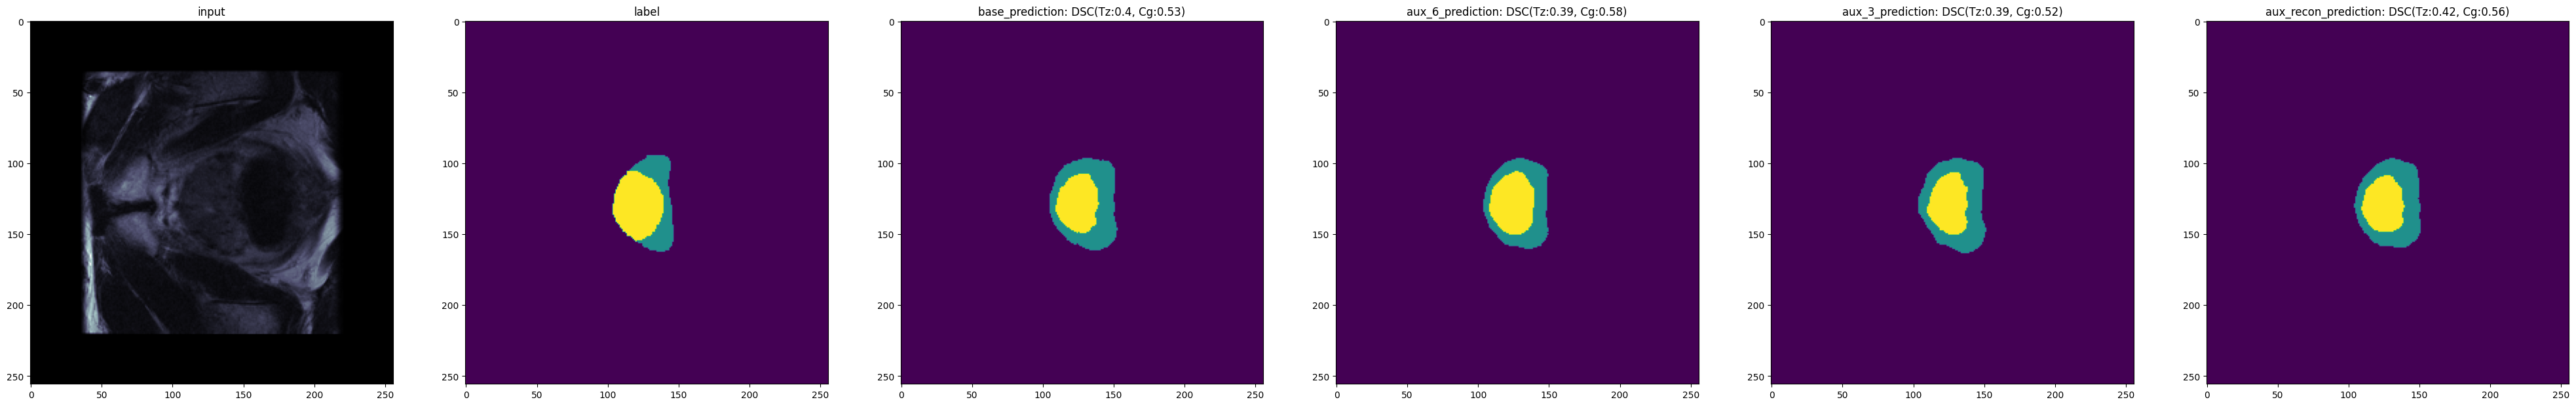

In [32]:
check_data = first(test_dl)
slice_idx = 22
organ = "Transition zone"
# Disable gradients as we are in inference mode
with torch.inference_mode():
    image, mask = check_data["image"][0].unsqueeze(dim = 0).permute(0, 1, 4, 2, 3).to(device), check_data["mask"][0].unsqueeze(dim = 0)
     # Modify the main labels to match output of main decoder
    mask[(mask != organs_dict['Transition zone']) & (mask != organs_dict['Central gland'])] = 0.0
    mask[mask == organs_dict['Transition zone']] = 1.0
    mask[mask == organs_dict['Central gland']] = 2.0
    
    # Forward pass to different models
    pred_base = base(image)
    pred_base = pred_base.permute(0, 1, 3, 4, 2).argmax(dim = 1).cpu()

    pred_main_2_aux_6 = main_2_aux_6(image)
    pred_main_2_aux_6 = pred_main_2_aux_6[0].permute(0, 1, 3, 4, 2).argmax(dim = 1).cpu()

    pred_main_2_aux_3 = main_2_aux_3(image)
    pred_main_2_aux_3 = pred_main_2_aux_3[0].permute(0, 1, 3, 4, 2).argmax(dim = 1).cpu()

    pred_main_2_aux_recon = main_2_aux_recon(image)
    pred_main_2_aux_recon = pred_main_2_aux_recon[0].permute(0, 1, 3, 4, 2).argmax(dim = 1).cpu()

    image = image.permute(0, 1, 3, 4, 2).cpu()
    # Make plots
    fig, axes = plt.subplots(1, 6, figsize = (50, 20))
    axes[0].imshow(image[0][0, :, :, slice_idx], cmap = "bone")
    axes[0].set_title("input")

    axes[1].imshow(mask[0][0, :, :, slice_idx])
    axes[1].set_title("label")

    axes[2].imshow(pred_base[0, :, :, slice_idx])
    axes[2].set_title("base_prediction: DSC(Tz:0.4, Cg:0.53)")

    axes[3].imshow(pred_main_2_aux_6[0, :, :, slice_idx])
    axes[3].set_title("aux_6_prediction: DSC(Tz:0.39, Cg:0.58)")

    axes[4].imshow(pred_main_2_aux_3[0, :, :, slice_idx])
    axes[4].set_title("aux_3_prediction: DSC(Tz:0.39, Cg:0.52)")

    axes[5].imshow(pred_main_2_aux_recon[0, :, :, slice_idx])
    axes[5].set_title("aux_recon_prediction: DSC(Tz:0.42, Cg:0.56)")
    
fig.savefig(f"mtl_model_weights\\worst_mtl_models_predictions_{slice_idx}.png", bbox_inches = "tight")  

## Visualize prediction from best performed image: 24

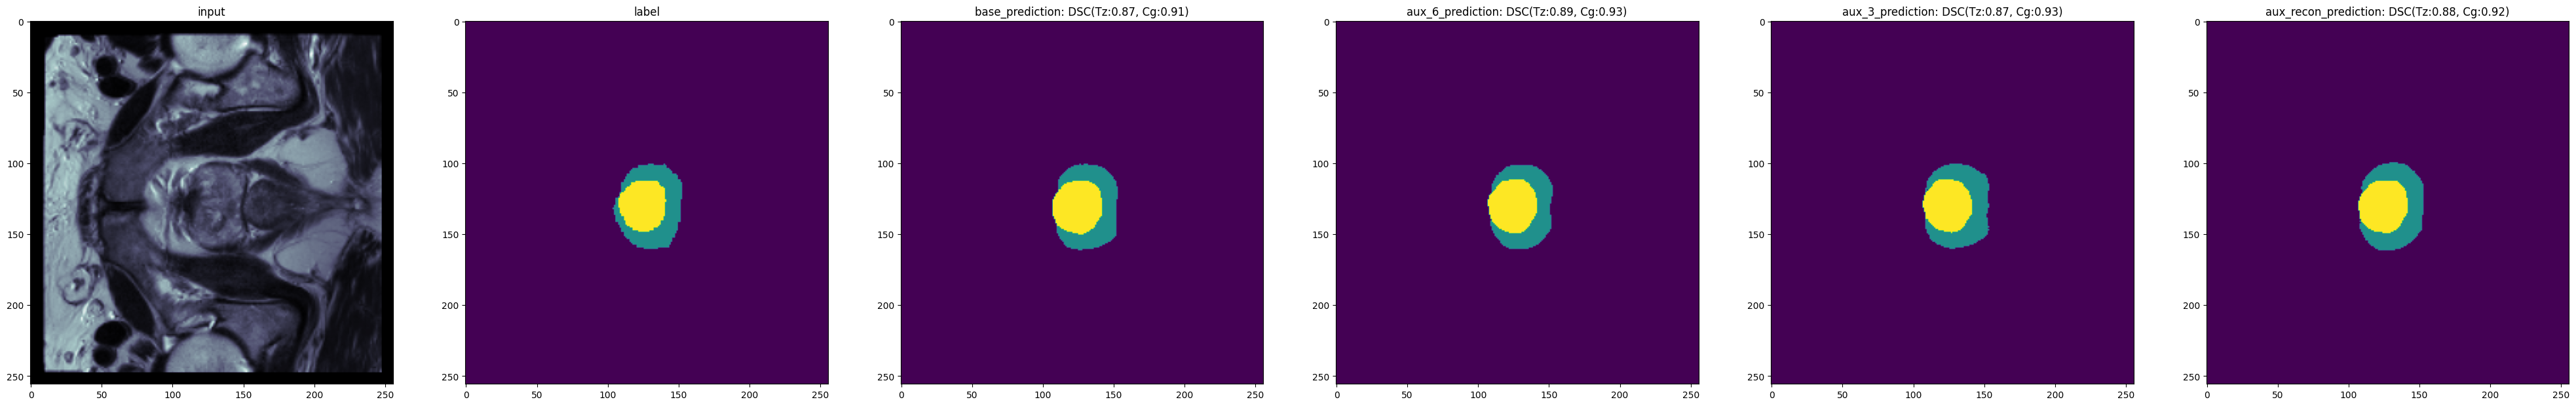

In [16]:
check_data = first(test_dl)
slice_idx = 15
organ = "Transition zone"
# Disable gradients as we are in inference mode
with torch.inference_mode():
    image, mask = check_data["image"][1].unsqueeze(dim = 0).permute(0, 1, 4, 2, 3).to(device), check_data["mask"][1].unsqueeze(dim = 0)
     # Modify the main labels to match output of main decoder
    mask[(mask != organs_dict['Transition zone']) & (mask != organs_dict['Central gland'])] = 0.0
    mask[mask == organs_dict['Transition zone']] = 1.0
    mask[mask == organs_dict['Central gland']] = 2.0
    
    # Forward pass to different models
    pred_base = base(image)
    pred_base = pred_base.permute(0, 1, 3, 4, 2).argmax(dim = 1).cpu()

    pred_main_2_aux_6 = main_2_aux_6(image)
    pred_main_2_aux_6 = pred_main_2_aux_6[0].permute(0, 1, 3, 4, 2).argmax(dim = 1).cpu()

    pred_main_2_aux_3 = main_2_aux_3(image)
    pred_main_2_aux_3 = pred_main_2_aux_3[0].permute(0, 1, 3, 4, 2).argmax(dim = 1).cpu()

    pred_main_2_aux_recon = main_2_aux_recon(image)
    pred_main_2_aux_recon = pred_main_2_aux_recon[0].permute(0, 1, 3, 4, 2).argmax(dim = 1).cpu()

    image = image.permute(0, 1, 3, 4, 2).cpu()
    # Make plots
    fig, axes = plt.subplots(1, 6, figsize = (50, 20))
    axes[0].imshow(image[0][0, :, :, slice_idx], cmap = "bone")
    axes[0].set_title("input")

    axes[1].imshow(mask[0][0, :, :, slice_idx])
    axes[1].set_title("label")

    axes[2].imshow(pred_base[0, :, :, slice_idx])
    axes[2].set_title("base_prediction: DSC(Tz:0.87, Cg:0.91)")

    axes[3].imshow(pred_main_2_aux_6[0, :, :, slice_idx])
    axes[3].set_title("aux_6_prediction: DSC(Tz:0.89, Cg:0.93)")

    axes[4].imshow(pred_main_2_aux_3[0, :, :, slice_idx])
    axes[4].set_title("aux_3_prediction: DSC(Tz:0.87, Cg:0.93)")

    axes[5].imshow(pred_main_2_aux_recon[0, :, :, slice_idx])
    axes[5].set_title("aux_recon_prediction: DSC(Tz:0.88, Cg:0.92)")
    
fig.savefig(f"mtl_model_weights\\best_mtl_models_predictions_{slice_idx}.png", bbox_inches = "tight")  

In [14]:
pred_main_2_aux_6[1].shape

torch.Size([1, 7, 40, 256, 256])

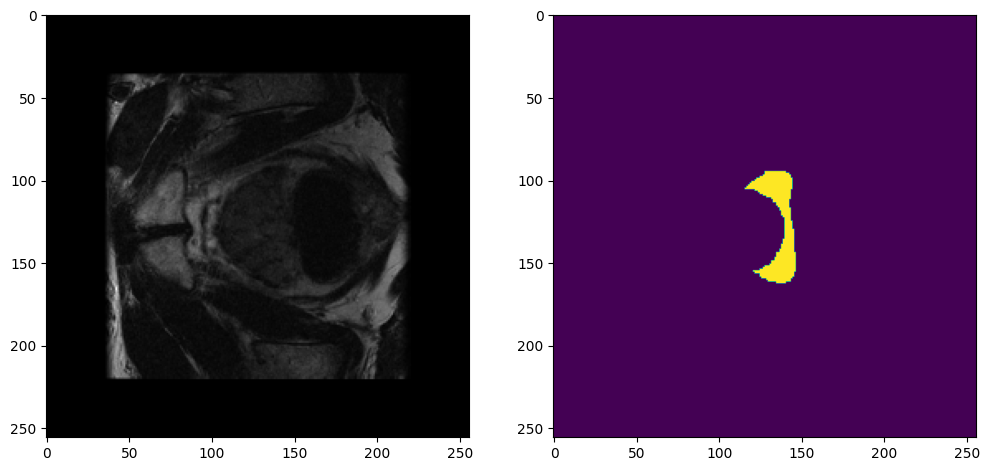

In [29]:
#check_data = first(test_dl)
slice_idx = 23
organ = "Transition zone" 
#organ = "Central gland"
timage, tmask = check_data["image"][0], check_data["mask"][0]
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].imshow(timage[0, :, :, slice_idx], cmap = "gray")
ax[1].imshow(tmask[0, :, :, slice_idx] == organs_dict[organ])
plt.show()

In [8]:
tmask.unique()

tensor([0., 1., 2.])

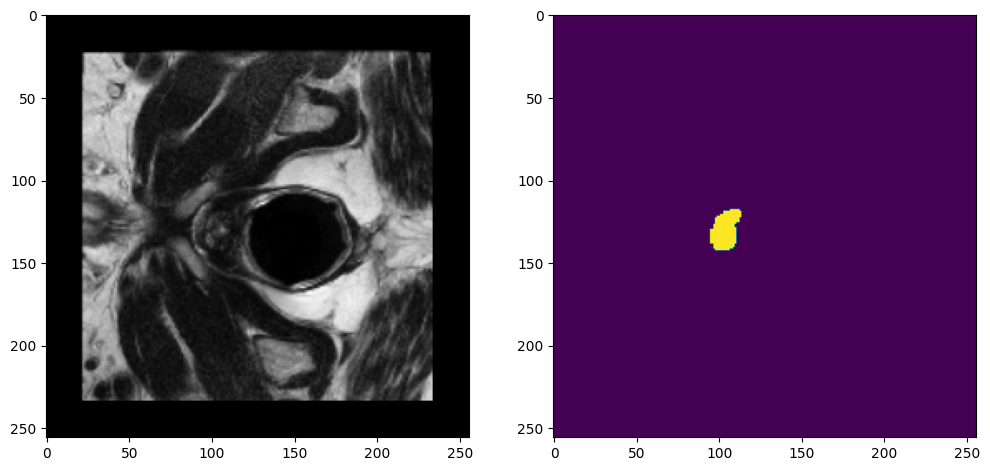

In [13]:
slice_idx = 15
#organ = "Transition zone" 
organ = "Central gland"
image, mask = check_data["image"][0], check_data["mask"][0]
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].imshow(image[0, :, :, slice_idx], cmap = "gray")
ax[1].imshow(mask[0, :, :, slice_idx] == organs_dict[organ])
plt.show()

In [ ]:
check_data["mask"][0].shape

In [ ]:
base.eval()
with torch.no_grad():
    for test_data in test_dl:
        test_inputs, test_labels = test_data["image"].permute(0, 1, 4, 2, 3).to(device), test_data["mask"].to(device)
        # Forward pass
        test_main_outputs = base(test_inputs)
        test_main_outputs = test_main_outputs.permute(0, 1, 3, 4, 2)
        plt.figure(figsize = (12, 6))
        plt.imshow(torch.argmax(test_main_outputs, dim = 1).cpu()[0, :, :, slice_idx])


In [ ]:
mask[0, :, :, :].unique()

In [ ]:
organs_dict

In [ ]:
organs_dict["Transition zone"]

In [ ]:
image.shape

In [ ]:
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
import matplotlib.pyplot as plt
def visualize(image, mask, index):
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    ax[0].imshow(image[0, :, :, index], cmap="gray")
    ax[1].imshow(mask[0, :, :, index])
    plt.show()
check_ds = Dataset(data = val_files, transform = val_transforms)
check_dl = DataLoader(check_ds, batch_size = 8, num_workers = 0)
check_data = first(check_dl)
image, mask = (check_data["image"][0], check_data["mask"][0])
print(f"Image shape: {image.shape}, mask shape {mask.shape}")
visualize(image, mask, 35)

In [23]:
val_files[0]["image"]
import nibabel as nib
import numpy as np

# Load the image
img = nib.load(val_files[0]["image"]).get_fdata()

img.shape



(199, 199, 36)